In [1]:
%load_ext autoreload
%autoreload

from retro_branching.utils import get_most_recent_checkpoint_foldername, PlotAesthetics

import glob
import gzip
import pickle
from collections import defaultdict
import copy
import numpy as np
import scipy.stats as st
import math
import sigfig

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tabulate import tabulate

# Config

In [183]:
# scip_params = 'default'
scip_params = 'gasse_2019'
# scip_params = 'dfs'

# # SET COVER 
# # n_rows=100 n_cols=100
# agent_to_path = {'IL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/gnn_341_checkpoint_120/rl_validator/rl_validator_1/',
#                  'RL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/dqn_gnn_1094_checkpoint_108/rl_validator/rl_validator_1/',
#                  'SB': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/strong_branching/rl_validator/rl_validator_1/',
#                  'PB': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/pseudocost/rl_validator/rl_validator_1/'}
# #                  'RPB': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/scip_branching/rl_validator/rl_validator_1/'}
agent_to_path = {'IL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/gnn_341_checkpoint_120/rl_validator/rl_validator_1/',
                 'RL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/dqn_gnn_1094_checkpoint_108/rl_validator/rl_validator_1/',
                 'SB': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/strong_branching/rl_validator/rl_validator_1/',
                 'PB': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/pseudocost/rl_validator/rl_validator_1/',
                 'Etheve': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/dqn_gnn_1393_checkpoint_201/rl_validator/rl_validator_1/'}

# # n_rows=165 n_cols=230
# agent_to_path = {'IL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_165_n_cols_230/baselines/gnn_356_checkpoint_104/rl_validator/rl_validator_1/',
#                  'RL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_165_n_cols_230/baselines/dqn_gnn_1407_checkpoint_370/rl_validator/rl_validator_1/',}


# # n_rows=500 n_cols=1000
# agent_to_path = {'IL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/baselines/gnn_343_checkpoint_233/rl_validator/rl_validator_1/',
#                  'RL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/baselines/dqn_gnn_1236_checkpoint_457/rl_validator/rl_validator_1/',
#                  'SB': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/baselines/strong_branching/rl_validator/rl_validator_1/',
#                  'PB': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/baselines/pseudocost/rl_validator/rl_validator_1/'}
# # agent_to_path = {'RL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/baselines/dqn_gnn_1094_checkpoint_108/rl_validator/rl_validator_1/',
# #                  'IL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/baselines/gnn_341_checkpoint_120/rl_validator/rl_validator_1/'}

# # n_rows=500 n_cols=1000 sub-tree ablation
# agent_to_path = {'Original': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/baselines/dqn_gnn_1405_checkpoint_60/rl_validator/rl_validator_1/',
#                  'Retrospective': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/baselines/dqn_gnn_1236_checkpoint_457/rl_validator/rl_validator_1/'}

# 500x1000 agent comparison (NEW)
agent_to_path = {
#                  'Retro': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_{scip_params}/baselines/dqn_gnn_1481_checkpoint_166/rl_validator/rl_validator_1/', # PAPER
                 'Retro': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_{scip_params}/baselines/dqn_gnn_1481_checkpoint_218/rl_validator/rl_validator_1/', # LATEST BEST
                 'Original': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_{scip_params}/baselines/dqn_gnn_1405_checkpoint_60/rl_validator/rl_validator_1/',
                 'FMSTS': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_{scip_params}/baselines/dqn_gnn_1484_checkpoint_74/rl_validator/rl_validator_1/',
                 'FMSTS-\nDFS': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_dfs/baselines/dqn_gnn_1484_checkpoint_74/rl_validator/rl_validator_1/',
                 'IL': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_{scip_params}/baselines/gnn_361_checkpoint_139/rl_validator/rl_validator_1/',
                 'PB': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_{scip_params}/baselines/pseudocost/rl_validator/rl_validator_1/',
                 'SB': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_{scip_params}/baselines/strong_branching/rl_validator/rl_validator_1/',
#                  'MAB-Retro': <path>,
                }

# # 165x230 agent comparison (NEW)
# agent_to_path = {
#                  'Retro': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_165_n_cols_230/scip_{scip_params}/baselines/dqn_gnn_1491_checkpoint_93/rl_validator/rl_validator_1/',
#                  'IL': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_165_n_cols_230/scip_{scip_params}/baselines/gnn_356_checkpoint_104/rl_validator/rl_validator_1/',
#                  'PB': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_165_n_cols_230/scip_{scip_params}/baselines/pseudocost/rl_validator/rl_validator_1/',
#                  'SB': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_165_n_cols_230/scip_{scip_params}/baselines/strong_branching/rl_validator/rl_validator_1/',
#                 }

# # 165x230 agents generalising to 500x1000 (NEW)
# agent_to_path = {
#                  'Retro': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_{scip_params}/baselines/dqn_gnn_1491_checkpoint_93/rl_validator/rl_validator_1/',
#                  'IL': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_{scip_params}/baselines/gnn_356_checkpoint_104/rl_validator/rl_validator_1/',
#                  'PB': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_{scip_params}/baselines/pseudocost/rl_validator/rl_validator_1/',
#                  'SB': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_{scip_params}/baselines/strong_branching/rl_validator/rl_validator_1/',
#                 }


# # 100x100 different subtree construction methods
# agent_to_path = {'MLG': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/dqn_gnn_1415_checkpoint_234/rl_validator/rl_validator_1/',
#                  'MG': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/dqn_gnn_1418_checkpoint_251/rl_validator/rl_validator_1/',
#                  'D': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/dqn_gnn_1414_checkpoint_311/rl_validator/rl_validator_1/',
#                  'RVO': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/dqn_gnn_1416_checkpoint_281/rl_validator/rl_validator_1/',
#                  'FIF': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/dqn_gnn_1376_checkpoint_213/rl_validator/rl_validator_1/',
#                  'AL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/dqn_gnn_1424_checkpoint_84/rl_validator/rl_validator_1/'}

# # 100x100 M-DQN and n-step DQN ablation
# agent_to_path = {'n-step M-DQN': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/dqn_gnn_1415_checkpoint_234/rl_validator/rl_validator_1/',
#                  'n-step DQN': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/dqn_gnn_1422_checkpoint_165/rl_validator/rl_validator_1/',
#                  'M-DQN': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/dqn_gnn_1423_checkpoint_159/rl_validator/rl_validator_1/'}

# # 250x500 different construction methods
# agent_to_path = {
#                  'MLG': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_250_n_cols_500/baselines/dqn_gnn_1451_checkpoint_40/rl_validator/rl_validator_1/',
#                  'D': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_250_n_cols_500/baselines/dqn_gnn_1452_checkpoint_19/rl_validator/rl_validator_1/',
#                  'R': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_250_n_cols_500/baselines/dqn_gnn_1453_checkpoint_42/rl_validator/rl_validator_1/',
#                  'MG': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_250_n_cols_500/baselines/dqn_gnn_1454_checkpoint_18/rl_validator/rl_validator_1/',
#                  'RVO': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_250_n_cols_500/baselines/dqn_gnn_1455_checkpoint_36/rl_validator/rl_validator_1/',
#                  'MLGF': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_250_n_cols_500/baselines/dqn_gnn_1457_checkpoint_20/rl_validator/rl_validator_1/',
#                 }



# # COMBINATORIAL AUCTION
# # n_items=10 n_bids=50
# agent_to_path = {
#                  'RL': '/scratch/datasets/retro_branching/instances/combinatorial_auction_n_items_10_n_bids_50/baselines/dqn_gnn_1379_checkpoint_73/rl_validator/rl_validator_1/',
#                  'IL': '/scratch/datasets/retro_branching/instances/combinatorial_auction_n_items_10_n_bids_50/baselines/gnn_347_checkpoint_124/rl_validator/rl_validator_1/',
#                  'PB': '/scratch/datasets/retro_branching/instances/combinatorial_auction_n_items_10_n_bids_50/baselines/pseudocost/rl_validator/rl_validator_1/',
#                  'SB': '/scratch/datasets/retro_branching/instances/combinatorial_auction_n_items_10_n_bids_50/baselines/strong_branching/rl_validator/rl_validator_1/',
#                 }



# # CAPACITATED FACILITY LOCATION
# # n_customers=5 n_facilities=5
# agent_to_path = {
#                  'RL': '/scratch/datasets/retro_branching/instances/capacitated_facility_location_n_customers_5_n_facilities_5/baselines/dqn_gnn_1382_checkpoint_10/rl_validator/rl_validator_1/',
#                  'IL': '/scratch/datasets/retro_branching/instances/capacitated_facility_location_n_customers_5_n_facilities_5/baselines/gnn_350_checkpoint_104/rl_validator/rl_validator_1/',
#                  'PB': '/scratch/datasets/retro_branching/instances/capacitated_facility_location_n_customers_5_n_facilities_5/baselines/pseudocost/rl_validator/rl_validator_1/',
#                  'SB': '/scratch/datasets/retro_branching/instances/capacitated_facility_location_n_customers_5_n_facilities_5/baselines/strong_branching/rl_validator/rl_validator_1/',
#                 }
# # n_customers=5 n_facilities=8
# agent_to_path = {
#                  'RL': '/scratch/datasets/retro_branching/instances/capacitated_facility_location_n_customers_5_n_facilities_5/baselines/dqn_gnn_1094_checkpoint_108/rl_validator/rl_validator_1/',
#                  'IL': '/scratch/datasets/retro_branching/instances/capacitated_facility_location_n_customers_5_n_facilities_8/baselines/gnn_351_checkpoint_69/rl_validator/rl_validator_1/',
#                  'PB': '/scratch/datasets/retro_branching/instances/capacitated_facility_location_n_customers_5_n_facilities_8/baselines/pseudocost/rl_validator/rl_validator_1/',
#                  'SB': '/scratch/datasets/retro_branching/instances/capacitated_facility_location_n_customers_5_n_facilities_8/baselines/strong_branching/rl_validator/rl_validator_1/',
#                 }
# n_customers=5 n_facilities=12
# agent_to_path = {
#                  'RL': '/scratch/datasets/retro_branching/instances/capacitated_facility_location_n_customers_5_n_facilities_5/baselines/dqn_gnn_1094_checkpoint_108/rl_validator/rl_validator_1/',
#                  'IL': '/scratch/datasets/retro_branching/instances/capacitated_facility_location_n_customers_5_n_facilities_12/baselines/gnn_352_checkpoint_131/rl_validator/rl_validator_1/',
#                  'PB': '/scratch/datasets/retro_branching/instances/capacitated_facility_location_n_customers_5_n_facilities_12/baselines/pseudocost/rl_validator/rl_validator_1/',
#                  'SB': '/scratch/datasets/retro_branching/instances/capacitated_facility_location_n_customers_5_n_facilities_12/baselines/strong_branching/rl_validator/rl_validator_1/',
#                 }



# # MAXIMUM INDEPENDENT SET
# # n_nodes=25
# agent_to_path = {
# #                  'RL': '/scratch/datasets/retro_branching/instances/maximum_independent_set_n_nodes_25/baselines/dqn_gnn_1383_checkpoint_101/rl_validator/rl_validator_1/',
#                  'RL': '/scratch/datasets/retro_branching/instances/maximum_independent_set_n_nodes_25/baselines/dqn_gnn_1390_checkpoint_384/rl_validator/rl_validator_1/',
#                  'SL': '/scratch/datasets/retro_branching/instances/maximum_independent_set_n_nodes_25/baselines/gnn_353_checkpoint_209/rl_validator/rl_validator_1/',
#                  'PB': '/scratch/datasets/retro_branching/instances/maximum_independent_set_n_nodes_25/baselines/pseudocost/rl_validator/rl_validator_1/',
#                  'SB': '/scratch/datasets/retro_branching/instances/maximum_independent_set_n_nodes_25/baselines/strong_branching/rl_validator/rl_validator_1/',
#                 }



winner_metric = 'num_nodes'

# use_calibration_times = True
use_calibration_times = False

verbose = True

# Core scripts

In [184]:
# load agent logs
agent_to_log = {}
agent_name_to_display_name = {}
for display_name, path in agent_to_path.items():
    path += get_most_recent_checkpoint_foldername(path)
    with gzip.open(*glob.glob(path+'/*log.pkl'), 'rb') as f:
        log = pickle.load(f)
    _agent_name = log['agent_names'][0]
    if agent_name in log:
        # agent with same original name being used multiple times, create new agent name
        agent_name += f'_{id(log["agent_names"][0])}'
        log[agent_name] = copy.deepcopy(log[_agent_name])
    else:
        agent_name = _agent_name
    agent_to_log[agent_name] = log
    agent_name_to_display_name[agent_name] = display_name
    
    num_instances = len(log[agent_name]["num_nodes"])
    print(f'Num evaluation instances solved in {display_name} agent log file: {num_instances}')

Num evaluation instances solved in Retro agent log file: 100
Num evaluation instances solved in Original agent log file: 100
Num evaluation instances solved in FMSTS agent log file: 100
Num evaluation instances solved in FMSTS-
DFS agent log file: 100
Num evaluation instances solved in IL agent log file: 100
Num evaluation instances solved in PB agent log file: 100
Num evaluation instances solved in SB agent log file: 100


In [185]:
# get stats for each agent
agent_to_stats = {agent: defaultdict(lambda: 0) for agent in agent_to_log.keys()}
for agent, log in agent_to_log.items():
    if use_calibration_times:
        agent_to_stats[agent]['calibrated_step_time'] = [np.array(elapsed_times).mean() for elapsed_times in log[agent]['elapsed_calibrated_step_time']]
        agent_to_stats[agent]['calibrated_inference_time'] = [np.array(elapsed_times).mean() for elapsed_times in log[agent]['elapsed_calibrated_inference_time']]
        agent_to_stats[agent]['calibrated_solve_time'] = [np.array(elapsed_times).sum() for elapsed_times in log[agent]['elapsed_calibrated_solve_time']] 
    #     agent_to_stats[agent]['calibrated_solve_time'] = [np.array(elapsed_times).sum() for elapsed_times in log[agent]['elapsed_calibrated_solves']] 
    #     agent_to_stats[agent]['calibrated_solve_time'] = [np.array(elapsed_times).sum() for elapsed_times in log[agent]['solve_time']]  

    agent_to_stats[agent]['num_nodes'] = [int(np.abs(np.array(nodes)).sum()) for nodes in log[agent]['num_nodes']]
    agent_to_stats[agent]['lp_iterations'] = [int(np.abs(np.array(nodes)).sum()) for nodes in log[agent]['lp_iterations']]
print(agent_to_stats)

{'dqn_gnn_1481_checkpoint_218': defaultdict(<function <dictcomp>.<lambda> at 0x7f5bf0a34200>, {'num_nodes': [42, 16, 6, 52, 6, 13, 18, 62, 50, 18, 54, 2, 79, 6, 18, 62, 25, 18, 14, 71, 40, 128, 66, 118, 55, 14, 54, 20, 18, 10, 16, 8, 54, 20, 8, 12, 62, 185, 14, 67, 144, 22, 6, 10, 147, 4, 18, 12, 44, 24, 64, 130, 64, 86, 84, 226, 62, 4, 134, 14, 188, 16, 142, 62, 26, 82, 46, 34, 8, 14, 8, 98, 256, 42, 54, 37, 8, 4, 18, 80, 62, 64, 14, 108, 52, 8, 18, 42, 24, 179, 10, 22, 12, 147, 8, 20, 32, 16, 30, 29], 'lp_iterations': [3016, 752, 203, 2317, 298, 733, 649, 3569, 3187, 1483, 3611, 65, 6160, 167, 1004, 3737, 1711, 1289, 822, 4556, 3578, 7942, 5260, 5432, 3982, 518, 1873, 750, 1018, 315, 712, 84, 2441, 779, 594, 379, 5852, 14659, 407, 4501, 7830, 660, 369, 501, 10444, 96, 1172, 346, 2345, 984, 4663, 8912, 4256, 7245, 7492, 14880, 3027, 190, 13708, 767, 11228, 1168, 9982, 2977, 1706, 3854, 3310, 1914, 397, 427, 363, 9481, 16144, 5113, 2321, 2541, 255, 246, 638, 4049, 4106, 2782, 543, 6752

In [186]:
# count # wins + draws for each agent (not including SB)
agent_to_score = defaultdict(lambda: 0)
for idx in range(num_instances):
    _agent_to_score = {}
    for agent, stats in agent_to_stats.items():
#         if agent != 'strong_branching' and agent != 'pseudocost':
        if agent != 'strong_branching':
            _agent_to_score[agent] = stats[winner_metric][idx]
    winner_score = min(list(_agent_to_score.values()))
    
    for agent in _agent_to_score.keys():
        if _agent_to_score[agent] <= winner_score:
            agent_to_score[agent] += 1
#     print(f'\nidx {idx} | _agent_to_score: {_agent_to_score} | winner_score: {winner_score} | agent_to_score: {agent_to_score}')

# for agent in agent_to_score:
#     print(agent, agent_to_score[agent])
agent_to_score_df = {'Agent': [], 'Score': []}
for agent, score in agent_to_score.items():
    agent_to_score_df['Agent'].append(agent_name_to_display_name[agent])
    agent_to_score_df['Score'].append(score)
agent_to_score_df = pd.DataFrame(agent_to_score_df)

In [187]:
# Create dataframes (from above dict) for data manipulation and seaborn plotting (use display_name for legends)
_df = defaultdict(list)
for agent in agent_to_stats.keys():
    for stat in agent_to_stats[agent].keys():
        try:
            for el in agent_to_stats[agent][stat]:
                _df[stat].append(el)
        except TypeError:
            # non-iterable, is already an element
            _df[stat].append(agent_to_stats[agent][stat])

for agent in agent_to_stats.keys():
    for _ in range(num_instances):
        _df['Agent'].append(agent_name_to_display_name[agent])
                        
for key, val in _df.items():
    print(key, len(val))
df = pd.DataFrame(_df)
if verbose:
    print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

num_nodes 700
lp_iterations 700
Agent 700
+-------------+-----------------+----------+
|   num_nodes |   lp_iterations | Agent    |
|-------------+-----------------+----------|
|          42 |            2990 | Retro    |
|          14 |             683 | Retro    |
|           6 |             209 | Retro    |
|          52 |            1764 | Retro    |
|           6 |             292 | Retro    |
|          15 |             918 | Retro    |
|          20 |             704 | Retro    |
|          68 |            3650 | Retro    |
|          51 |            4076 | Retro    |
|          18 |            1473 | Retro    |
|          50 |            3554 | Retro    |
|           2 |              65 | Retro    |
|          69 |            3849 | Retro    |
|           6 |             163 | Retro    |
|          14 |             930 | Retro    |
|          54 |            3690 | Retro    |
|          24 |            1862 | Retro    |
|          16 |            1017 | Retro    |
|          14

# Plots

In [188]:
# config
estimator = np.mean # np.mean np.median
# estimator = np.median
# estimator = st.iqr
# estimator = st.gmean
# context = 'paper'
# style = 'white'
# font_scale = 2
# palette = 'hls'
# ci = 68
ci = None
errcolor = 'gray'
capsize = 0.05
# fig_size = (7.5, 1.5) # wide
# fig_size = (3.5, 2)
# fig_size = (7, 2)
# fig_size = (7.5, 2)
# fig_size = (5.5, 5)
# fig_size = (6.5, 5)

# xaxis_label = 'Agent'
xaxis_label = ''

y_offset = 0 # 165x230
# y_offsert = 0.3
# y_offset = 5 # 500x1000
# y_offset = 150

# loc = 'bottom'
loc = 'top'

# ylog = False
ylog = True

xlog = False
# xlog = True

display_values = True

# scaling_factor = 0.6
# width_scaling_factor = 1
print(order)
# height_scaling_factor = 1
scaling_factor = 1
# width_scaling_factor = 1
width_scaling_factor = 1.4
height_scaling_factor = 0.5

order = None
order = list(df.groupby('Agent')['num_nodes'].mean().sort_values().index)[::-1]
print(f'order: {order}')

hue_order = list(agent_to_path.keys())
print(f'hue_order: {hue_order}')

aesthetics = PlotAesthetics()
aesthetics.set_icml_paper_plot_aesthetics()

['Retro', 'IL', 'PB', 'SB']
order: ['Original', 'FMSTS-\nDFS', 'FMSTS', 'PB', 'Retro', 'IL', 'SB']
hue_order: ['Retro', 'Original', 'FMSTS', 'FMSTS-\nDFS', 'IL', 'PB', 'SB']


In [189]:
def show_values_on_bars(axs, sigfigs=2, y_offset=0, loc='top'):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            if loc == 'top':
                _x = p.get_x() + p.get_width() / 2
    #             _y = p.get_y() + p.get_height()
    #             _y = p.get_y() + y_offset
                _y = p.get_height() + y_offset
                value = sigfig.round(p.get_height(), sigfigs=sigfigs)
                ax.text(_x, _y, value, ha="center") 
            elif loc == 'bottom':
                _x = p.get_x() + p.get_width() / 2
    #             _y = p.get_y() + p.get_height()
                _y = p.get_y() + y_offset
                value = sigfig.round(p.get_height(), sigfigs=sigfigs)
                ax.text(_x, _y, value, ha="center") 
            else:
                raise Exception(f'Unrecognised loc {loc}')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [190]:
# generate colour for each agent given hue order and colour palette
_palette = iter(sns.color_palette(aesthetics.palette))
palette = {agent: next(_palette) for agent in hue_order}
print(palette)

{'Retro': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Original': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'FMSTS': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'FMSTS-\nDFS': (0.8352941176470589, 0.3686274509803922, 0.0), 'IL': (0.8, 0.47058823529411764, 0.7372549019607844), 'PB': (0.792156862745098, 0.5686274509803921, 0.3803921568627451), 'SB': (0.984313725490196, 0.6862745098039216, 0.8941176470588236)}


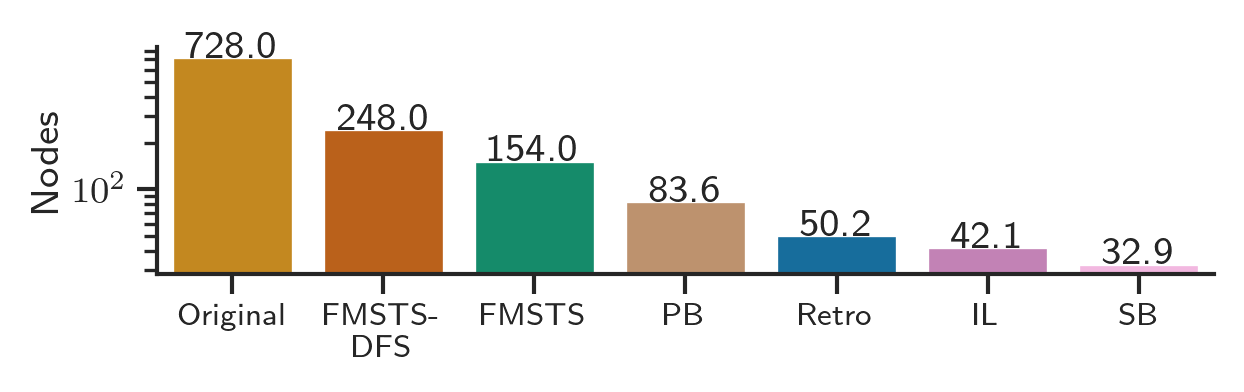

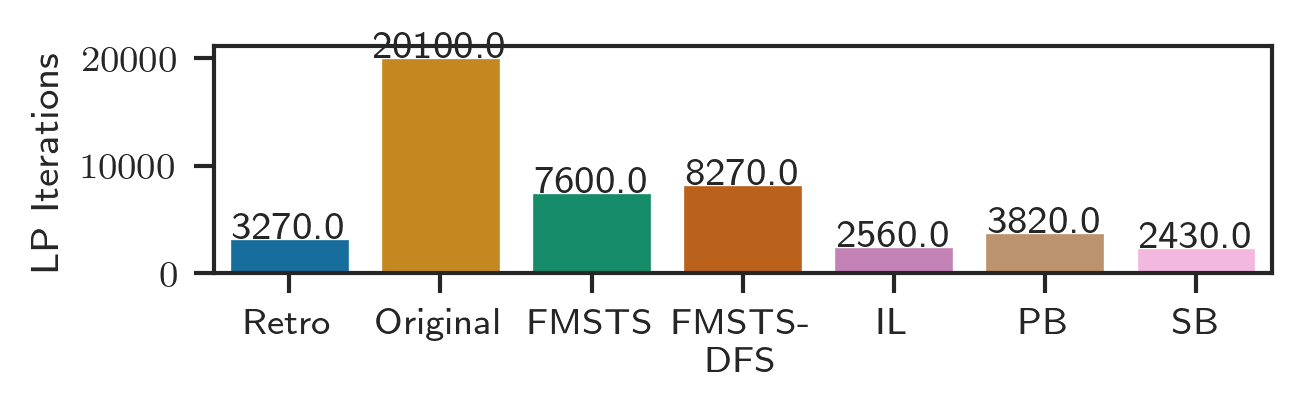

/scratch/zciccwf/py36/envs/rlgnn/lib/python3.7/site-packages/sigfig/sigfig.py:572: UserWarning: warning: 3 significant figures requested from number with only 2 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


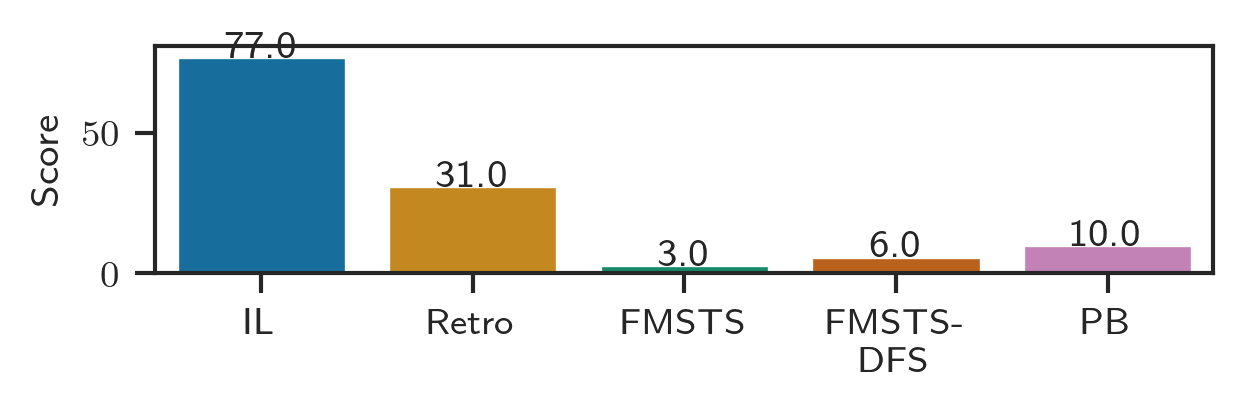

In [191]:
# sns.set_theme(font_scale=font_scale,
#               context=context,
#               style=style,
#               palette=palette)

f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
g = sns.barplot(data=df,
                x='Agent',
                y='num_nodes',
                order=order,
                palette=palette,
                estimator=estimator,
                ci=ci,
                errcolor=errcolor,
                capsize=capsize)
g.set_xlabel(xaxis_label)
g.set_ylabel('Nodes')
ax.tick_params(axis='both', which='major', pad=2)
plt.xticks(fontsize=7.5)
ax.xaxis.labelpad = 2
# ax.xaxis.label.set_size(2)
ax.yaxis.labelpad = 2
sns.despine(ax=ax) # remove top and right spines
if ylog:
    g.set(yscale='log')
if xlog:
    g.set(xscale='log')
if display_values:
    show_values_on_bars(ax, sigfigs=3, y_offset=y_offset, loc=loc)
plt.gcf().patch.set_alpha(0.0)
plt.show()

f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
g = sns.barplot(data=df,
                x='Agent',
                y='lp_iterations',
                estimator=estimator,
                ci=ci,
                errcolor=errcolor,
                capsize=capsize)
g.set_xlabel(xaxis_label)
g.set_ylabel('LP Iterations')
if display_values:
    show_values_on_bars(ax, sigfigs=3, loc=loc)
plt.show()

if 'calibrated_inference_time' in df.columns:
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.barplot(data=df,
                    x='Agent',
                    y='calibrated_inference_time',
                    estimator=estimator,
                    ci=ci,
                    errcolor=errcolor,
                    capsize=capsize)
    g.set_xlabel(xaxis_label)
    g.set_ylabel('Cal. Inference Time (s)')
    if display_values:
        show_values_on_bars(ax, sigfigs=3, loc=loc)
    plt.show()

if 'calibrated_step_time' in df.columns:
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.barplot(data=df,
                    x='Agent',
                    y='calibrated_step_time',
                    estimator=estimator,
                    ci=ci,
                    errcolor=errcolor,
                    capsize=capsize)
    g.set_xlabel(xaxis_label)
    g.set_ylabel('Cal. Step Time (s)')
    if display_values:
        show_values_on_bars(ax, sigfigs=3, loc=loc)
    plt.show()

if 'calibrated_solve_time' in df.columns:
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.barplot(data=df,
                    x='Agent',
                    y='calibrated_solve_time',
                    estimator=estimator,
                    ci=ci,
                    errcolor=errcolor,
                    capsize=capsize)
    g.set_xlabel(xaxis_label)
    g.set_ylabel('Cal. Solve Time (s)')
    if display_values:
        show_values_on_bars(ax, sigfigs=3, loc=loc)
    plt.show()

f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
g = sns.barplot(data=agent_to_score_df,
                x='Agent',
                y='Score',
#                 estimator=estimator,
                ci=ci,
                errcolor=errcolor,
                capsize=capsize)
g.set_xlabel(xaxis_label)
g.set_ylabel('Score')
if display_values:
    show_values_on_bars(ax, sigfigs=3, loc=loc)
plt.show()